In [1]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import seaborn as sns
import numpy as np
from scipy import stats

In [2]:


# Load the dataset
file_path = 'dubizzle_cars_dataset.csv'
df = pd.read_csv(file_path,index_col=None)

# Display the first few rows of the dataset
# display(df.head())

# Display the summary of the dataset
# display(df.info())

# # Display the basic statistics of the dataset
# display(df.describe())

# # Check for missing values
# display(df.isnull().sum())

# # Display the columns of the dataset
# print(df.columns)

# # Display the data types of each column
# print(df['trim'].value_counts())


In [3]:
df=df.dropna(subset=['trim'])
df.head()

,price,brand,model,trim,kilometers,year,vehicle_age_years,regional_specs,doors,body_type,...,interior_color,warranty,address,country,city,area_name,location_name,latitude,longitude,seller_type
0,129900,Dodge,Ram,1500 SLT Crew,47566,2021,3,GCC Specs,4,Pick Up Truck,...,Unknown,Yes,"Al Khabaisi, Deira, Dubai, UAE",UAE,Dubai,Deira,Al Khabaisi,25.266173,55.337772,Dealership/Certified Pre-Owned
1,319900,Alfa Romeo,Stelvio,Quadrifoglio,8914,2020,4,GCC Specs,5,SUV,...,Black,Yes,"Abu Hail, Deira, Dubai, UAE",UAE,Dubai,Deira,Abu Hail,25.275416,55.346450,Dealership/Certified Pre-Owned
2,149900,Audi,Q5,S-line,72205,2019,5,GCC Specs,5,SUV,...,Brown,Yes,"Al Khabaisi, Deira, Dubai, UAE",UAE,Dubai,Deira,Al Khabaisi,25.266173,55.337772,Dealership/Certified Pre-Owned
3,79900,Alfa Romeo,GIULIETTA,Veloce,49193,2021,3,GCC Specs,4,Hatchback,...,Black,Yes,"Al Khabaisi, Deira, Dubai, UAE",UAE,Dubai,Deira,Al Khabaisi,25.266173,55.337772,Dealership/Certified Pre-Owned
4,154900,GAC,GS8,GL,30,2024,0,GCC Specs,5,SUV,...,Other Color,Yes,"Al Khabaisi, Deira, Dubai, UAE",UAE,Dubai,Deira,Al Khabaisi,25.266173,55.337772,Dealership/Certified Pre-Owned


In [4]:
df['warranty'].unique()

array(['Yes', 'No', 'Does not apply'], dtype=object)

In [5]:
# regional_specs,body_type,fuel_type,transmission_type,horsepower,warranty,seller_type,engine_capacity_cc

columns_to_remove = ['address', 'area_name', 'location_name', 'latitude', 'longitude','vehicle_age_years','country','interior_color','exterior_color','city','body_type','horsepower','engine_capacity_cc']
df_cleaned = df.drop(columns=columns_to_remove)
display(df_cleaned.head())

,price,brand,model,trim,kilometers,year,regional_specs,doors,fuel_type,seating_capacity,transmission_type,no_of_cylinders,warranty,seller_type
0,129900,Dodge,Ram,1500 SLT Crew,47566,2021,GCC Specs,4,Petrol,5,Automatic Transmission,8,Yes,Dealership/Certified Pre-Owned
1,319900,Alfa Romeo,Stelvio,Quadrifoglio,8914,2020,GCC Specs,5,Petrol,5,Automatic Transmission,6,Yes,Dealership/Certified Pre-Owned
2,149900,Audi,Q5,S-line,72205,2019,GCC Specs,5,Petrol,5,Automatic Transmission,4,Yes,Dealership/Certified Pre-Owned
3,79900,Alfa Romeo,GIULIETTA,Veloce,49193,2021,GCC Specs,4,Petrol,5,Automatic Transmission,4,Yes,Dealership/Certified Pre-Owned
4,154900,GAC,GS8,GL,30,2024,GCC Specs,5,Petrol,7,Automatic Transmission,4,Yes,Dealership/Certified Pre-Owned


In [6]:
brand_model_trim_dict = df.groupby(['brand', 'model'])['trim'].apply(list).to_dict()

# Initialize a dictionary to hold the final structure
brand_model_trim_dict_final = {}

# Populate the dictionary with the nested structure
for (brand, model), trims in brand_model_trim_dict.items():
    if brand not in brand_model_trim_dict_final:
        brand_model_trim_dict_final[brand] = {}
    # Remove duplicates and trim whitespace from trims
    trims = list(dict.fromkeys([trim.strip() for trim in trims if isinstance(trim, str)]))
    # Add the model with its trims
    brand_model_trim_dict_final[brand][model.strip()] = trims

# Display the dictionary to verify
print("\nBrand-Model-Trim Dictionary without duplicates and trimmed:")
print(brand_model_trim_dict_final['Nissan'])

import json
with open('brand_model_dict.json', 'w') as f:
    json.dump(brand_model_trim_dict_final, f)


Brand-Model-Trim Dictionary without duplicates and trimmed:
{'300ZX': ['Other'], '370z': ['Nismo'], 'Altima': ['SV', 'SL', 'S', 'Other', 'SR', 'SE'], 'Armada': ['SL', 'SE', 'Platinum', 'LE', 'SV', 'Titanium'], 'GT-R': ['Other'], 'Juke': ['Nismo', 'Other', 'S', 'SL', 'SV', 'SL Turbo'], 'Kicks': ['SV', 'Other', 'SL', 'S', 'SV Plus'], 'Maxima': ['Other', 'SE', 'SR', 'S', 'SL', 'SV'], 'Micra': ['SL', 'Other', 'SV', 'S'], 'Murano': ['LE', 'SL'], 'Navara': ['SE', 'CSPF', 'LE'], 'Pathfinder': ['SV', 'SL', 'S', 'SE', 'S 4WD', 'Platinum', 'LE', 'Other', 'XE'], 'Patrol': ['LE Platinum City', 'LE Titanium', 'SE P2', 'Other', 'XE', 'LE', 'Super Safari', 'LE Platinum', 'Basic', 'SE Platinum', 'Safari', 'Nismo', 'SE', 'SE P5', 'SE Platinum City', 'Safari AT', 'GL', 'LE Platinum + FES'], 'Pickup': ['Double Cab'], 'Qashqai': ['SE'], 'Quest': ['SV'], 'Rogue': ['Other', 'Standard'], 'Sentra': ['SV', 'S FE Plus', 'S', 'SL', 'SR', 'Other', 'SV Sport'], 'Sunny': ['SE', 'SV', 'S', 'Base', 'SL', 'SV Comfort

In [7]:
print("\nTypes of each column:")
display(df_cleaned.dtypes)


Types of each column:


price                 int64
brand                object
model                object
trim                 object
kilometers            int64
year                  int64
regional_specs       object
doors                 int64
fuel_type            object
seating_capacity      int64
transmission_type    object
no_of_cylinders       int64
warranty             object
seller_type          object
dtype: object

In [8]:
df_cleaned['brand'] = df_cleaned['brand'].str.strip().str.title()
df_cleaned['model'] = df_cleaned['model'].str.strip().str.title()
df_cleaned['trim'] = df_cleaned['trim'].str.strip().str.title()
df_cleaned['warranty'] = df_cleaned['warranty'].str.strip().str.title()
display(df_cleaned['warranty'].unique())
df_cleaned['regional_specs'] = df_cleaned['regional_specs'].str.strip().str.title()
df_cleaned['seller_type'] = df_cleaned['seller_type'].str.strip().str.title()

array(['Yes', 'No', 'Does Not Apply'], dtype=object)

In [9]:
columns_to_convert = [
    'brand','model','trim','regional_specs', 'fuel_type', 'transmission_type', 
    'warranty','seller_type'
]

# df_cleaned[columns_to_convert] = df_cleaned[columns_to_convert].fillna('Unknown')

categories = [
    'brand','model','trim','regional_specs', 'fuel_type', 'transmission_type', 
    'warranty', 'seller_type','no_of_cylinders','seating_capacity','doors'
]

# Convert the columns to categorical
for column in columns_to_convert:
    df_cleaned[column] = df_cleaned[column].str.strip().str.title()
    df_cleaned[column] = df_cleaned[column].astype('category')  
  
display(df_cleaned.dtypes)     

price                   int64
brand                category
model                category
trim                 category
kilometers              int64
year                    int64
regional_specs       category
doors                   int64
fuel_type            category
seating_capacity        int64
transmission_type    category
no_of_cylinders         int64
warranty             category
seller_type          category
dtype: object

In [10]:
df['warranty'].unique()

array(['Yes', 'No', 'Does not apply'], dtype=object)

In [11]:
# for column in columns_to_convert:
#     print(f"Categories for {column}:")
#     print(df_cleaned[column].cat.categories)

In [12]:
df_cleaned = df_cleaned.drop_duplicates()


In [13]:
df_cleaned.head()

,price,brand,model,trim,kilometers,year,regional_specs,doors,fuel_type,seating_capacity,transmission_type,no_of_cylinders,warranty,seller_type
0,129900,Dodge,Ram,1500 Slt Crew,47566,2021,Gcc Specs,4,Petrol,5,Automatic Transmission,8,Yes,Dealership/Certified Pre-Owned
1,319900,Alfa Romeo,Stelvio,Quadrifoglio,8914,2020,Gcc Specs,5,Petrol,5,Automatic Transmission,6,Yes,Dealership/Certified Pre-Owned
2,149900,Audi,Q5,S-Line,72205,2019,Gcc Specs,5,Petrol,5,Automatic Transmission,4,Yes,Dealership/Certified Pre-Owned
3,79900,Alfa Romeo,Giulietta,Veloce,49193,2021,Gcc Specs,4,Petrol,5,Automatic Transmission,4,Yes,Dealership/Certified Pre-Owned
4,154900,Gac,Gs8,Gl,30,2024,Gcc Specs,5,Petrol,7,Automatic Transmission,4,Yes,Dealership/Certified Pre-Owned


In [14]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# # Scatter plot of Price vs. Mileage
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='kilometers', y='price', data=df_cleaned)
# plt.title('Price vs. Mileage')
# plt.xlabel('Mileage')
# plt.ylabel('Price')
# plt.show()

# # Scatter plot of Price vs. Year
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='year', y='price', data=df_cleaned)
# plt.title('Price vs. Year')
# plt.xlabel('Year')
# plt.ylabel('Price')
# plt.show()


# # Count plot of Car Brands
# plt.figure(figsize=(14, 16))
# sns.countplot(y='brand', data=df_cleaned, order=df_cleaned['brand'].value_counts().index)
# plt.title('Count of Cars by Brand')
# plt.xlabel('Count')
# plt.ylabel('Brand')
# plt.show()

# # Boxplot of Car Prices by Brand
# plt.figure(figsize=(14, 16))
# sns.boxplot(x='price', y='brand', data=df_cleaned)
# plt.title('Boxplot of Car Prices by Brand')
# plt.xlabel('Price')
# plt.ylabel('Brand')
# plt.show()

In [15]:
display(df_cleaned.dtypes)

price                   int64
brand                category
model                category
trim                 category
kilometers              int64
year                    int64
regional_specs       category
doors                   int64
fuel_type            category
seating_capacity        int64
transmission_type    category
no_of_cylinders         int64
warranty             category
seller_type          category
dtype: object

In [16]:
print("before encoding: ")
display(df_cleaned['seller_type'].unique())

before encoding: 


['Dealership/Certified Pre-Owned', 'Owner', 'Dealer']
Categories (3, object): ['Dealer', 'Dealership/Certified Pre-Owned', 'Owner']

In [17]:
target_encoding_cols = ['brand', 'model','trim']
target_encodings={}
for col in target_encoding_cols:
    mean_target = df_cleaned.groupby(col)['price'].mean()
    df_cleaned[col + '_encoded'] = df_cleaned[col].map(mean_target)
    target_encodings[col]=mean_target
df_cleaned.drop(target_encoding_cols, axis=1, inplace=True)    
joblib.dump(target_encodings, 'target_encodings.pkl')

C:\Users\hp\AppData\Local\Temp\ipykernel_8056\595983013.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_target = df_cleaned.groupby(col)['price'].mean()
C:\Users\hp\AppData\Local\Temp\ipykernel_8056\595983013.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_target = df_cleaned.groupby(col)['price'].mean()
C:\Users\hp\AppData\Local\Temp\ipykernel_8056\595983013.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this war

['target_encodings.pkl']

In [18]:
df_cleaned.head()

,price,kilometers,year,regional_specs,doors,fuel_type,seating_capacity,transmission_type,no_of_cylinders,warranty,seller_type,brand_encoded,model_encoded,trim_encoded
0,129900,47566,2021,Gcc Specs,4,Petrol,5,Automatic Transmission,8,Yes,Dealership/Certified Pre-Owned,113578.972222,207046.115385,144950.000000
1,319900,8914,2020,Gcc Specs,5,Petrol,5,Automatic Transmission,6,Yes,Dealership/Certified Pre-Owned,159036.230769,189242.714286,313589.909091
2,149900,72205,2019,Gcc Specs,5,Petrol,5,Automatic Transmission,4,Yes,Dealership/Certified Pre-Owned,139180.110320,91242.107143,102535.032258
3,79900,49193,2021,Gcc Specs,4,Petrol,5,Automatic Transmission,4,Yes,Dealership/Certified Pre-Owned,159036.230769,71439.866667,113913.500000
4,154900,30,2024,Gcc Specs,5,Petrol,7,Automatic Transmission,4,Yes,Dealership/Certified Pre-Owned,91072.636364,132500.000000,50370.277778


In [19]:
from sklearn.preprocessing import Normalizer

# Ensure the columns are properly categorized
categorical_columns = [
    'regional_specs', 'fuel_type', 'transmission_type', 
    'warranty','seller_type','no_of_cylinders','seating_capacity','doors'
]

numerical_columns = ['kilometers', 'year','brand_encoded','model_encoded','trim_encoded']

label_encoders={}
for col in categorical_columns:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoders[col] = le

scaler_y = MinMaxScaler()
df_cleaned['price'] = scaler_y.fit_transform(df_cleaned['price'].values.reshape(-1, 1)).flatten() 

# Use OneHotEncoder for the rest of the categorical variables
# onehot_columns = [col for col in categorical_columns if col not in label_enc_columns]
# encoder = OneHotEncoder(sparse_output=False, drop='first')
# encoded_features = encoder.fit_transform(df_cleaned[onehot_columns])

# Create a DataFrame with the encoded features
# encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(onehot_columns))

# Ensure indices align before concatenation
# encoded_df.index = df_cleaned.index

# Concatenate the original DataFrame (excluding the original one-hot encoded columns) with the encoded DataFrame
# df_encoded = pd.concat([df_cleaned.drop(columns=onehot_columns), encoded_df], axis=1)


# Use StandardScaler to normalize numerical features
scaler_x = Normalizer()
df_encoded=df_cleaned
df_encoded[numerical_columns] = scaler_x.fit_transform(df_encoded[numerical_columns])
# Serialize the scalers
joblib.dump(scaler_x, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')


['label_encoders.pkl']

In [20]:
# target_encoding_cols = ['brand', 'model','trim']
# for col in target_encoding_cols:
#     mean_target = df_encoded.groupby(col)['price'].mean()
#     df_encoded[col + '_encoded'] = df_encoded[col].map(mean_target)
# df_encoded.drop(target_encoding_cols, axis=1, inplace=True)    

In [21]:
print('after encoding:')
display(df_encoded)

after encoding:


,price,kilometers,year,regional_specs,doors,fuel_type,seating_capacity,transmission_type,no_of_cylinders,warranty,seller_type,brand_encoded,model_encoded,trim_encoded
0,0.129042,0.169184,0.007188,4,2,3,3,0,5,2,1,0.403980,0.736426,0.515561
1,0.319251,0.022318,0.005057,4,3,3,3,0,4,2,1,0.398179,0.473807,0.785135
2,0.149064,0.346486,0.009688,4,3,3,3,0,2,2,1,0.667876,0.437838,0.492029
3,0.078987,0.229873,0.009444,4,2,3,3,0,2,2,1,0.743156,0.333829,0.532303
4,0.154069,0.000178,0.012012,4,3,3,5,0,2,2,1,0.540495,0.786357,0.298936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9948,0.214236,0.493392,0.005208,4,2,3,0,0,5,0,0,0.386496,0.676786,0.386158
9949,0.077085,0.350287,0.004276,4,2,3,3,0,5,0,0,0.608980,0.446017,0.554520
9950,0.172189,0.424343,0.006390,4,2,3,5,0,4,2,0,0.360277,0.687404,0.466442
9951,0.062068,0.795253,0.005515,4,3,3,5,0,4,0,0,0.311983,0.403512,0.327699


In [22]:
df_encoded.shape[1]

14

In [23]:
# # Group by brand and model
# grouped = df_encoded.groupby(['brand', 'model','year'])

# def remove_outliers(group):
#     z_scores = np.abs(stats.zscore(group['price']))
#     threshold = 3
#     return group[z_scores <= threshold]

# # Apply the outlier removal function to each group
# df_no_outliers = grouped.apply(remove_outliers).reset_index(drop=True)

# # Check the shape of the data before and after removing outliers
# print(f"Original dataset shape: {df_cleaned.shape}")
# print(f"Dataset shape after removing outliers: {df_no_outliers.shape}")


In [24]:
df_encoded.head()

,price,kilometers,year,regional_specs,doors,fuel_type,seating_capacity,transmission_type,no_of_cylinders,warranty,seller_type,brand_encoded,model_encoded,trim_encoded
0,0.129042,0.169184,0.007188,4,2,3,3,0,5,2,1,0.403980,0.736426,0.515561
1,0.319251,0.022318,0.005057,4,3,3,3,0,4,2,1,0.398179,0.473807,0.785135
2,0.149064,0.346486,0.009688,4,3,3,3,0,2,2,1,0.667876,0.437838,0.492029
3,0.078987,0.229873,0.009444,4,2,3,3,0,2,2,1,0.743156,0.333829,0.532303
4,0.154069,0.000178,0.012012,4,3,3,5,0,2,2,1,0.540495,0.786357,0.298936


In [25]:

# Split the data into training and testing sets
X = df_encoded.drop(columns=['price'])
y = df_encoded['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = xgb_model.predict(X_test)

joblib.dump(xgb_model,'xgb_model.pkl')

# Calculate metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)



print(f"\nXGBoost Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")




XGBoost Model Performance:
RMSE: 0.1040
R²: 0.7070
MAE: 0.0504


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [26]:
display(df_encoded.dtypes)

price                float64
kilometers           float64
year                 float64
regional_specs         int32
doors                  int64
fuel_type              int32
seating_capacity       int64
transmission_type      int32
no_of_cylinders        int64
warranty               int32
seller_type            int32
brand_encoded        float64
model_encoded        float64
trim_encoded         float64
dtype: object

In [27]:
# Example test input
test_input = {
    'brand': ['Nissan'],
    'model': ['Maxima'],
    'trim': ['Sr'],
    'kilometers': [225000],
    'year': [2016],
    'regional_specs': ['American Specs'],
    'doors': ['4'],
    'fuel_type': ['Petrol'],
    'seating_capacity': ['5'],
    'transmission_type': ['Automatic Transmission'],
    'no_of_cylinders': ['6'],
    'warranty': ['Does Not Apply'],
    'seller_type': ['Dealership/Certified Pre-Owned'],
}

test_df = pd.DataFrame(test_input)

# Load scalers and encoders
scaler_x = joblib.load('scaler_X.pkl')
scaler_y = joblib.load('scaler_y.pkl')
label_encoders = joblib.load('label_encoders.pkl')
target_encodings = joblib.load('target_encodings.pkl')

# Apply label encoders
for col in categorical_columns:
    le = label_encoders[col]
    test_df[col] = le.transform(test_df[col])

for col in target_encoding_cols:
    mean_target = target_encodings[col]
    test_df[col + '_encoded'] = test_df[col].map(mean_target)    

test_df.drop(target_encoding_cols, axis=1, inplace=True)
# Apply standard scaler to numerical columns
test_df[numerical_columns] = scaler_x.transform(test_df[numerical_columns])

# Load the trained model
xgb_model = joblib.load('xgb_model.pkl')

# Make predictions
y_pred = xgb_model.predict(test_df)

# Inverse transform the predicted price to get the actual value
predicted_price = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f"Predicted price: {predicted_price[0]:.2f}")


Predicted price: 31266.58


In [164]:
# plt.subplot(1, 3, 3)
# plt.scatter(y_test, y_pred, alpha=0.3)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.title('XGBoost: Actual vs. Predicted')

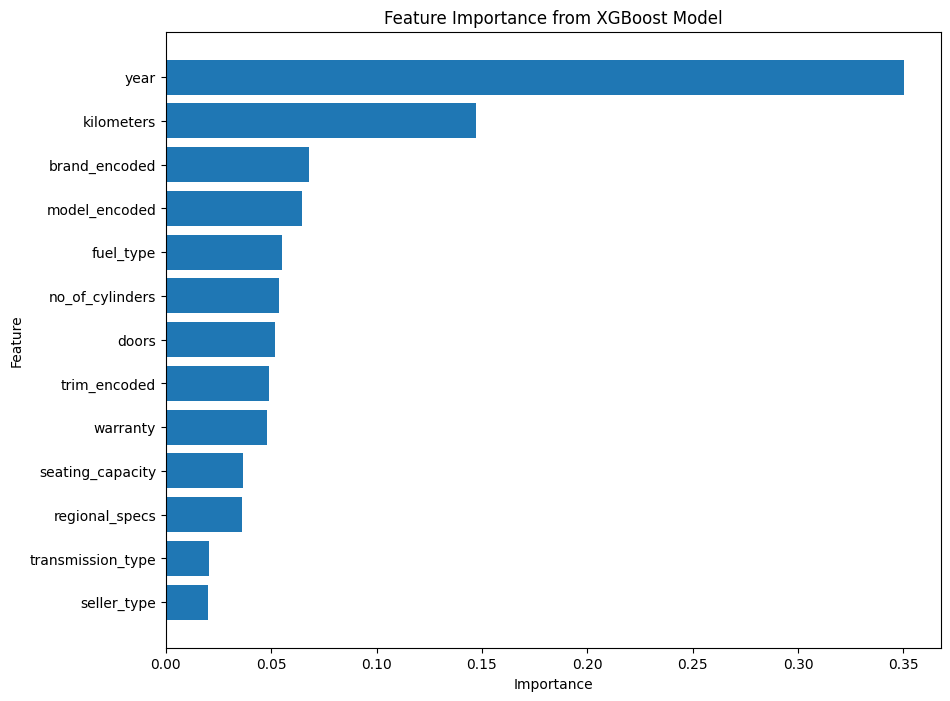

In [165]:
feature_importance = xgb_model.feature_importances_
features = df_encoded.drop(columns=['price']).columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from XGBoost Model')
plt.gca().invert_yaxis()
plt.show()

In [166]:
# Serialize the trained model
joblib.dump(xgb_model, 'xgb_model.pkl')



['xgb_model.pkl']

In [167]:
# for col, encoder in label_encoders.items():
#     print(f"Column: {col}")
#     # print(f"Classes: {encoder.classes_}")
#     print()
print(label_encoders.items())

dict_items([('regional_specs', LabelEncoder()), ('fuel_type', LabelEncoder()), ('transmission_type', LabelEncoder()), ('warranty', LabelEncoder()), ('seller_type', LabelEncoder()), ('no_of_cylinders', LabelEncoder()), ('seating_capacity', LabelEncoder()), ('doors', LabelEncoder())])


In [168]:
display(df_no_outliers)

NameError: name 'df_no_outliers' is not defined